In [49]:
### Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, wilcoxon, shapiro
import statsmodels.api as sm
import html
from IPython.display import display, HTML

## Data Analysis

This notebook analyzes evaluation results comparing AI-generated chart interpretations under two conditions:

1. **Image only**: o4-mini receives chart without context
2. **Image + context**: o4-mini receives chart with surrounding textual context

Each interpretation was evaluated on four quality dimensions using 7-point Likert scales:
- Accuracy
- Clarity  
- Relevance
- Completeness

Plus an overall preference rating.

### Research Questions

1. Do context-enhanced interpretations score higher on quality dimensions?
2. Which condition do evaluators prefer overall?
3. How do the quality dimensions correlate with each other?

###  1. Dataset Loading & Preparation

In [92]:
### --- Reading the data ---
df_raw = pd.read_csv('data/evaluation_results.csv')

### --- Restructuring the DataFrame to long format ---
metrics = ['accuracy', "clarity", "relevance", "completeness"]
conditions = ["with_context", "without_context"]

# Converting the dataset to long format
long_rows = []
for _, row in df_raw.iterrows():
    for cond in conditions:
        long_rows.append({
            "item_index": row.item_index,
            "condition": cond,
            **{m: row[f"{cond}_{m}"] for m in metrics},
            "overall": sum(row[f"{cond}_{m}"] for m in metrics)/len(metrics),
            "preference": row.preference_actual
        })

# Save the long format DataFrame
df = pd.DataFrame(long_rows)

### 2. Addressing Research Questions

#### 2.1 Do context-enhanced interpretations score higher on quality dimensions?

To answer this question, a paired statistical tests (e.g., paired t-test or Wilcoxon signed-rank if non-normal) on per-item differences was conducted to assess whether context yields significant improvements.

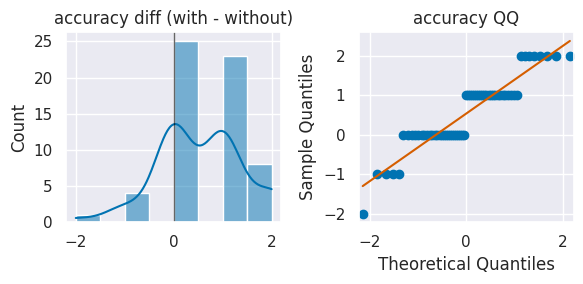

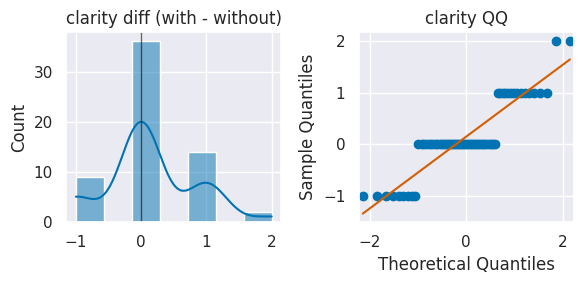

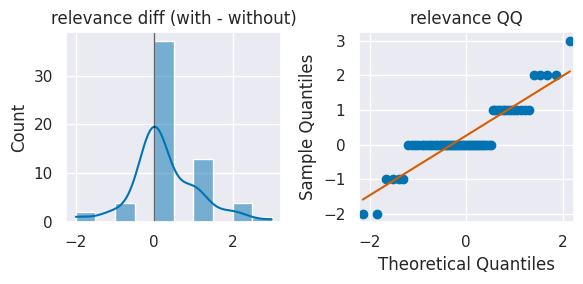

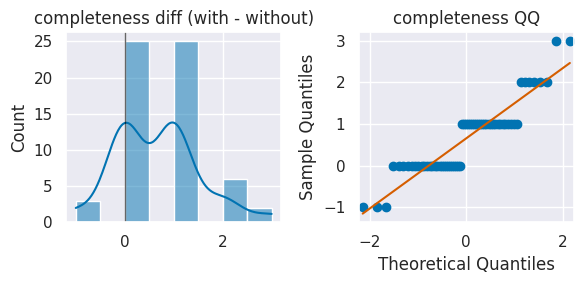

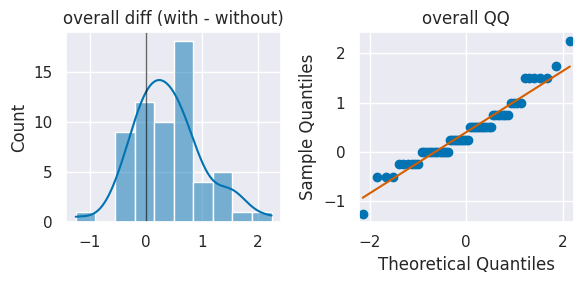

         metric  n_pairs  mean_diff  std_diff  shapiro_p_rounded
0      accuracy       61   0.540984  0.867444            0.00002
1       clarity       61   0.147541  0.703232            0.00000
2     relevance       61   0.262295  0.873721            0.00000
3  completeness       61   0.655738  0.854113            0.00001
4       overall       61   0.401639  0.626296            0.02332


In [93]:
### --- Plotting the distribution of differences & QQ plot ---
q_dims = metrics + ["overall"]

shapiro_rows = []
for q in q_dims:
    wide_q = df.pivot(index="item_index", columns="condition", values=q)
    diff = wide_q["with_context"] - wide_q["without_context"]
    diff_clean = diff.dropna()
    
    # Prepare figure
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    sns.histplot(diff_clean, kde=True, ax=axes[0])
    axes[0].set_title(f"{q} diff (with - without)")
    axes[0].axvline(0, color="black", lw=1, alpha=0.6)
    sm.qqplot(diff_clean, line="s", ax=axes[1])
    axes[1].set_title(f"{q} QQ")
    plt.tight_layout()
    plt.show()
    
    # Shapiro test (needs at least 3 values; meaningful if n >= 8)
    if len(diff_clean) >= 3:
        p = shapiro(diff_clean).pvalue
    else:
        p = np.nan
    shapiro_rows.append({
        "metric": q,
        "n_pairs": len(diff_clean),
        "mean_diff": diff_clean.mean(),
        "std_diff": diff_clean.std(ddof=1),
        "shapiro_p": p
    })

shapiro_df = pd.DataFrame(shapiro_rows)
shapiro_df["shapiro_p_rounded"] = shapiro_df["shapiro_p"].round(5)
print(shapiro_df[["metric","n_pairs","mean_diff","std_diff","shapiro_p_rounded"]])

In [94]:
### --- Statistical Tests for Differences in Quality Dimensions ---

# Performing Shapiro-Wilk test for normality
rows = []
for q in q_dims:
    w = df.pivot(index="item_index", columns="condition", values=q)[["without_context","with_context"]].dropna()
    if w.empty: 
        continue
    diff = w["with_context"] - w["without_context"]
    t_stat, p_t = ttest_rel(w["with_context"], w["without_context"])
    w_stat, p_w = wilcoxon(diff)  # two-sided
    rows.append({
        "metric": q,
        "n": len(w),
        "mean_with": w["with_context"].mean(),
        "mean_without": w["without_context"].mean(),
        "mean_diff": diff.mean(),
        "t_p": p_t,
        "wilcoxon_p": p_w
    })

stats_df = pd.DataFrame(rows).round({"mean_with":3,"mean_without":3,"mean_diff":3,"t_p":4,"wilcoxon_p":4})
print(stats_df)

         metric   n  mean_with  mean_without  mean_diff     t_p  wilcoxon_p
0      accuracy  61      6.590         6.049      0.541  0.0000      0.0000
1       clarity  61      6.623         6.475      0.148  0.1065      0.1047
2     relevance  61      6.820         6.557      0.262  0.0224      0.0291
3  completeness  61      6.803         6.148      0.656  0.0000      0.0000
4       overall  61      6.709         6.307      0.402  0.0000      0.0000


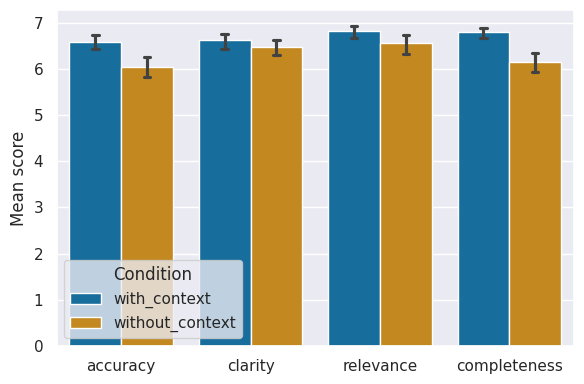

In [ ]:
### --- Visualizing the Quality Dimensions mean scores ---
sns.set_theme(palette="colorblind")

mean_long = df.melt(id_vars=["condition"], value_vars=metrics,
                    var_name="q_dims", value_name="score")
plt.figure(figsize=(6,4))
sns.barplot(data=mean_long, x="q_dims", y="score", hue="condition", errorbar=('ci', 95), capsize=.1)
plt.ylabel("Mean score")
plt.xlabel("")
plt.legend(title="Condition")
plt.tight_layout()

### 2.2 Investigating overall preference between conditions


Chart Interpretations generated with context were preferred 45 times.

Chart Interpretations generated without context were preferred 8 times.

Chart Interpretations were preferred equally 8 times.


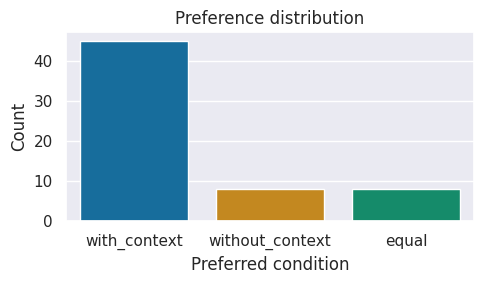

In [96]:
### --- Visualizing the Preference Distribution ---
preference_df = df.drop_duplicates("item_index")
counts = preference_df['preference'].value_counts()

plt.figure(figsize=(5,3))
sns.countplot(data=preference_df, x="preference",
              order=["with_context","without_context","equal"], hue="preference")
plt.xlabel("Preferred condition")
plt.ylabel("Count")
plt.title("Preference distribution")
plt.tight_layout()

print(f"\nChart Interpretations generated with context were preferred {counts.get('with_context', 0)} times.")
print(f"\nChart Interpretations generated without context were preferred {counts.get('without_context', 0)} times.")
print(f"\nChart Interpretations were preferred equally {counts.get('equal', 0)} times.")

### 2.3 Quality Dimensions Correlations

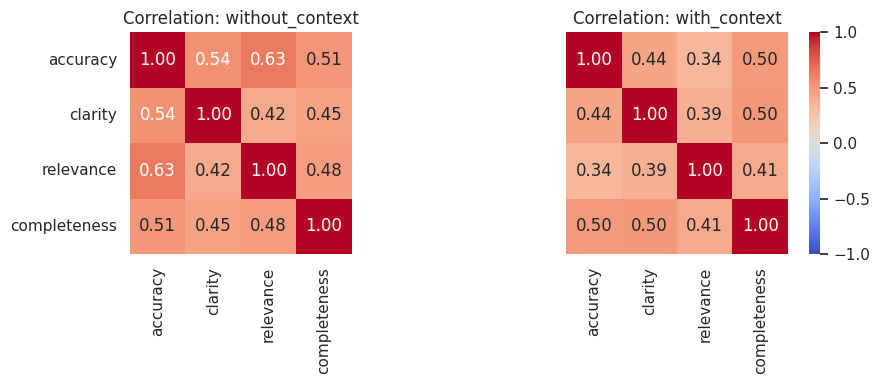

In [ ]:
### --- Visualizing the Correlation Matrix ---
# Plotting the correlation matrix for each condition
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True)

for ax, cond in zip(axes, ["without_context","with_context"]):
    sub = df[df["condition"] == cond][metrics]
    corr = sub.corr()
    sns.heatmap(corr, vmin=-1, vmax=1, cmap="coolwarm", annot=True, fmt=".2f",
                square=True, cbar=(cond=="with_context"), ax=ax)
    ax.set_title(f"Correlation: {cond}")

plt.tight_layout()

### 3. Error Analysis

This section will outline the common and uncommon errors that the model made across the two conditions.

Simple charts were interpreted quite well even without the context (items 6, 12, 33)

Common errors in no context condition:

- Lacking contextual grounding
- Lacking detail
- Misinterpreting domain-specific terms

Common errors in context condition:
- Adding informative detail, however, underivable from the chart image (e.g., items 7, 23, 30)


Other items to possibly note 
- 1 (both didn't mention an aspect of the chart); 
- 7, 23, 30 (example of refraining the interpretation to the chart only, where as other description adds more information not derivable from the chart itself);
- 48 (making different claims about the chart);
- 50, 52, 56 (big difference between scores, no context condition much worse + ???).

NB (7, 23, 30 - include e.gs., of no context refraining the interpretation to the chart only)
    

In [66]:
### --- Loading the Images & Responses ---
# Helper functions
img_df = pd.read_csv('data/evaluation_ready.csv')
good_interpretations = [5, 11, 32]
extra_detail = [6, 22, 29]
wrong_claims = [47]
large_differences = [49, 51, 55, 58]

items = good_interpretations + extra_detail + wrong_claims + large_differences
items.sort()

def show_card(row, img_width=420):
    def esc(x): return html.escape("" if pd.isna(x) else str(x))
    display(HTML(f"""
    <div style="display:grid; grid-template-columns: {img_width}px 1fr 1fr; gap:12px; margin:10px 0; padding:12px; border:1px solid #e5e7eb; border-radius:8px; font-family:system-ui, sans-serif;">
      <div><img src="{esc(row['image_path_1'])}" style="max-width:100%; height:auto; border:1px solid #eee;"/></div>
      <div><div style="font-weight:600; margin-bottom:6px;">With context</div>
           <div style="white-space:pre-wrap; line-height:1.4;">{esc(row['with_context'])}</div></div>
      <div><div style="font-weight:600; margin-bottom:6px;">Without context</div>
           <div style="white-space:pre-wrap; line-height:1.4;">{esc(row['without_context'])}</div></div>
    </div>
    """))


#### Examples of good interpretations across both conditions

In [60]:
### --- Good Interpretations in Both Conditions ---
for _, r in img_df.loc[good_interpretations].iterrows():
    show_card(r)

#### Examples of Interpretations having extra detail from context

In [ ]:
### --- Chart & Chart interpretations that include extra detail underivable from the context ---
for _, r in img_df.loc[extra_detail].iterrows():
    show_card(r)

In [63]:
### --- Chart & Chart interpretations where the claims are plain wrong ---
for _, r in img_df.loc[wrong_claims].iterrows():
    show_card(r)

In [64]:
### --- Chart & Chart interpretations that had a large difference in scores between conditions ---
for _, r in img_df.loc[large_differences].iterrows():
    show_card(r)